# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="./data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
3382,3382,직장 내 괴롭힘 대화,김과장 이런말 오해없이 들어\n네 부장님\n김과장은 회장님 옆에서 있는 사람이니 단...
3009,3009,직장 내 괴롭힘 대화,김선생님 이따 저녁에 뭐하세요?\n아무 일정 없습니다. 원장선생님.\n그래요? 잘됐...
3500,3500,기타 괴롭힘 대화,의사선생님 \n네\n저번에 다녀갔는데 대체 왜 아직도 안 낫죠?\n예 원래 2주정도...
3322,3322,기타 괴롭힘 대화,뭘 봐 못생긴게\n 니가 더 못생겼어\n 뭐라는거야 얼굴 아스팔트에 붙은 껌같이 생...
94,94,직장 내 괴롭힘 대화,자네. 야간 당직은 자네가 서게.\n네? 오늘은 제 차례가 아닙니다.\n상사가 하라...
2338,2338,협박 대화,김사장. 우리 그동안의 세월을 봐서 내가 많이 봐줬다.\n한번만 더 시간을 주면 안...
1793,1793,일반 대화,간식으로 뭐 먹어?\n과일이나 과자 먹어.\n어떤 음식 좋아해?\n나는 일식 좋아해...
2030,2030,갈취 대화,어이!거기 시계 좋아보이네\n근데 뭐\n뭐?말이 짧네\n니가 먼저 반말해놓고 기분 ...
519,519,협박 대화,니네가족 한참 좋을때지?\n죄송합니다. \n죄송?이라는말 필요없고 내가 전에 얘기한...
857,857,협박 대화,너 . 김디귿이랑 바람 폈냐 .?\n 뭐 .? 무슨 말도 안 되는 소리야 .\n 그...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## Augmentation

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['conversation'].apply(preprocess_sentence)

#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [15]:
# 불용어 리스트 불러오기
stopwords_path = "./preprocess/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install sentencepiece```  
```!pip install konlpy```

In [16]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

토크나이저 선정
1. SentencePiece  
[ref](https://wikidocs.net/86657)

```
# sentencePiece의 입력으로 사용하기 위해서 데이터를 txt 파일로 저장
with open('./preprocess/conversations.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['conversation']))
# 소요 시간이 너무 길어져 vocab size 15000으로 줄임
spm.SentencePieceTrainer.train(
    input='./preprocess/conversations.txt', 
    model_prefix='./preprocess/dktc',
    vocab_size=15000,
    model_type='bpe',
    max_sentence_length=9999
)
```

In [17]:
sp = spm.SentencePieceProcessor(model_file='./preprocess/dktc.model')

2. konlpy  
1) Okt  
2) Mecab

In [18]:
# okt, mecab 토크나이저 정의
okt=Okt()
mecab=Mecab()

토크나이저 비교

In [19]:
sources = train_data['conversation'].sample(4)
count=1
for source in sources:
    print(f"sentence {count}: {source}")
    count+=1
    # SentencePiece
    print("SentencePiece Tokenizer: ")
    print(sp.encode_as_pieces(source))
    # Okt
    print("Okt Tokenizer: ")
    print(okt.morphs(source))
    # Mecab
    print("Mecab Tokenizer: ")
    print(mecab.morphs(source))

sentence 1: 아 진짜 너한테서 냄새나  왜그래 .   너네집 거지냐 ?  물 안나오냐 ?   그런거 아니야 .   뭘 아니야 딱봐도 안씻어서 냄새나는데 더럽게  너네 왜그래  너때문에 교실에 못있겠잖아 짜증나게  너네 그러지마 나 씻었어  지하네 뒤질래 ?   하 . 그만해 . 
SentencePiece Tokenizer: 
['▁아', '▁진짜', '▁너한테서', '▁냄새나', '▁왜그래', '▁.', '▁너네집', '▁거지냐', '▁?', '▁물', '▁안나', '오냐', '▁?', '▁그런거', '▁아니야', '▁.', '▁뭘', '▁아니야', '▁딱봐도', '▁안씻', '어서', '▁냄새나', '는데', '▁더럽게', '▁너네', '▁왜그래', '▁너때문에', '▁교실', '에', '▁못', '있', '겠', '잖아', '▁짜증나게', '▁너네', '▁그러지마', '▁나', '▁씻', '었어', '▁지', '하네', '▁뒤질래', '▁?', '▁하', '▁.', '▁그만해', '▁.']
Okt Tokenizer: 
['아', '진짜', '너', '한', '테', '서', '냄새', '나', '왜', '그래', '.', '너', '네', '집', '거지', '냐', '?', '물', '안', '나오냐', '?', '그런거', '아니야', '.', '뭘', '아니야', '딱', '봐도', '안', '씻어서', '냄새', '나는데', '더럽게', '너', '네', '왜', '그래', '너', '때문', '에', '교실', '에', '못', '있겠잖아', '짜증나게', '너', '네', '그러지마', '나', '씻었어', '지하', '네', '뒤질래', '?', '하', '.', '그만해', '.']
Mecab Tokenizer: 
['아', '진짜', '너', '한테서', '냄새', '나', '왜', '그래', '.', '너', '네', '집', '거지', '냐', '?', '물', '안', '나오', '냐', '?', '그런', '거', '아니',

**-> Okt 토크나이저 활용**

#### 토큰화 적용

In [20]:
# 토큰화 수행 함수
def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, okt))

#### 단어사전 생성

In [21]:
# vocabulary 파일로 저장
def save_vocab(tokenized, vocab_path):
    # 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
    all_tokens = [token for tokens in tokenized for token in tokens]
    counter = Counter(all_tokens)
    # 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
    counter = counter.most_common(VOCAB_SIZE)
    
    with open(vocab_path, 'w') as f:
        f.write("<pad>: 0\n")
        f.write("<unk>: 1\n")
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx+2}\n"
            f.write(line)
            
vocab_path = './preprocess/vocab.txt'
#save_vocab(train_data['tokenized'], vocab_path)

In [22]:
def create_word_to_index(vocab_path):
    # 인코딩에 활용할 단어사전 딕셔너리 생성
    word_to_index = {}
    with open(vocab_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            tmp = line.split(": ")
            word = tmp[0]
            idx = int(tmp[1])
            word_to_index.update({word: idx})
    return word_to_index

In [23]:
word_to_index=create_word_to_index(vocab_path)
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '!': 5,
 '내': 6,
 '해': 7,
 '뭐': 8,
 '는': 9,
 '도': 10,
 '좋아해': 11,
 '거': 12,
 '말': 13,
 '다': 14,
 '은': 15,
 '돈': 16,
 '친구': 17,
 '잘': 18,
 '니': 19,
 '있어': 20,
 '랑': 21,
 '요': 22,
 '영화': 23,
 '만': 24,
 '진짜': 25,
 '이야': 26,
 '정말': 27,
 '죄송합니다': 28,
 '한': 29,
 '게': 30,
 '지금': 31,
 '할': 32,
 '고': 33,
 '하고': 34,
 '한테': 35,
 '오늘': 36,
 '주로': 37,
 '님': 38,
 '주말': 39,
 '그냥': 40,
 '여행': 41,
 '돼': 42,
 '집': 43,
 '많이': 44,
 '자주': 45,
 '제발': 46,
 '가족': 47,
 '알': 48,
 '생각': 49,
 '거야': 50,
 '적': 51,
 '이랑': 52,
 '하는': 53,
 '더': 54,
 '운동': 55,
 '지': 56,
 '그렇게': 57,
 '너무': 58,
 '했어': 59,
 '빨리': 60,
 '회사': 61,
 '새끼': 62,
 '씨': 63,
 '만나': 64,
 '하면': 65,
 '아니야': 66,
 '없어': 67,
 '걸': 68,
 '수': 69,
 '애': 70,
 '면': 71,
 '줄': 72,
 '그런': 73,
 '이렇게': 74,
 '그게': 75,
 '그건': 76,
 '어제': 77,
 '서': 78,
 '이제': 79,
 '넌': 80,
 '대리': 81,
 '인데': 82,
 '사진': 83,
 '나도': 84,
 '엄마': 85,
 '아침': 86,
 '다녀': 87,
 '취미': 88,
 '부모님': 89,
 '만원': 90,
 '싶어': 91,
 '본': 92,
 '뭘': 93,
 '

#### 정수인코딩

In [24]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [25]:
train_data.sample(3)

,conversation,type,tokenized,encoded
3733,야 니가 요번 대화 일등이라며 ? 응 왜 ? 엥 이딴게 일등이라고 ? 가 아니...,3,"[니, 요, 번, 대화, 일등, 이라, 며, ?, ?, 엥, 이딴, 게, 일등, 이...","[19, 22, 181, 787, 5105, 285, 1262, 3, 3, 1625..."
338,"가족이랑 자주 만나 ? 응 , 매주 주말에 만나 . 부모님은 뭐 하셔 ? 아...",4,"[가족, 이랑, 자주, 만나, ?, ,, 매주, 주말, 만나, ., 부모님, 은, ...","[47, 52, 45, 64, 3, 4, 407, 39, 64, 2, 89, 15,..."
4083,꼬마야 돈 있냐 없어요 주머니에 보인다 이거 돈 아니에요 내놔 제발요 학원비라구요 ...,1,"[꼬마, 돈, 있냐, 없어요, 주머니, 보인다, 거, 돈, 아니에요, 내놔, 제발,...","[2177, 16, 516, 119, 816, 1176, 12, 16, 352, 1..."


## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

최대 길이: 303
최소 길이: 11
평균 길이: 74.31515151515151
표준편차: 31.087848215261783


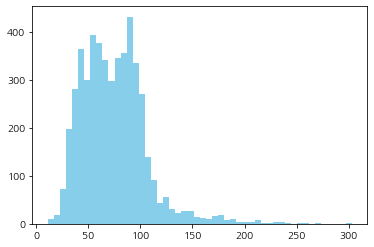

In [26]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [27]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [28]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [29]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


In [30]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_test)
counter.most_common()

[(4, 116), (3, 115), (0, 95), (1, 89), (2, 80)]